In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from keras.models import Model
from keras.layers import Input, Dense

from evaluation import model_evaluation, backtest

2024-05-23 19:21:38.764608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
stats = pd.read_csv('data/PlayersStats_1971-2024.csv')
shares = pd.read_csv('data/SharesMVP_1971-2024.csv')

# Merge stats and shares
data = stats.merge(shares, how = 'left', on = ['href', 'Year'], suffixes = ['', '_y']).drop(columns = ['Player_y'])
data = data[data['Year'] >= 1980]
data = data.fillna(0.)
data = data[((data['G'] >= 15) & (data['MP'] >= 5)) | (data['Share'] > 0)]
data = data.reset_index(drop = True)

start_year = 1988

In [3]:
features = ['VORP', 'WS', 'OWS', 'BPM', 'PER', 'PTS', 'FTA', 'OBPM', 'FG', 'USG%', 'MP', 'GS', 'Seed', 'W/L%']
features_norm = ['VORP', 'WS', 'OWS', 'BPM', 'PER', 'PTS', 'FTA', 'OBPM', 'FG', 'USG%', 'MP', 'GS']

In [4]:
# Calculate means and stds by year
means = data.groupby('Year')[features_norm].transform('mean')
stds = data.groupby('Year')[features_norm].transform('std')

# Standardize features
data_norm = data.copy()
data_norm[features_norm] = (data[features_norm] - means) / stds

In [5]:
def summarize_backtest(backtests) :
    for metric in backtests.columns[-7:] :
        print(metric, backtests[metric].mean())

## Random Forest

### Normalized data?

In [15]:
backtests_ = backtest(start_year, data.copy(), RandomForestRegressor(), features)
backtests_norm = backtest(start_year, data_norm.copy(), RandomForestRegressor(), features)

print('\nRaw data')
summarize_backtest(backtests_)

print('\nStandardized data')
summarize_backtest(backtests_norm)

KeyboardInterrupt: 

No significant improvements from standardizing the data

### Hyperparameters tuning

In [ ]:
backtests_01 = backtest(start_year, data.copy(), RandomForestRegressor(min_samples_leaf = 0.1), features)
backtests_05 = backtest(start_year, data.copy(), RandomForestRegressor(min_samples_leaf = 0.5), features)

print('\n10%')
summarize_backtest(backtests_01)

print('\n50%')
summarize_backtest(backtests_05)

[37/37] ... 2024 ...   
10%
Correct 0.05405405405405406
R2 0.08260278110898636
MAE 0.012052037452954929
MAE w. votes 0.17271679712714966
Tau 0.34230515683871987
Top-3 0.13513513513513511
Top-5 0.2216216216216216

50%
Correct 0.0
R2 9.132659418619092e-07
MAE 0.013887829572991017
MAE w. votes 0.17563811452480982
Tau nan
Top-3 0.02702702702702703
Top-5 0.016216216216216217


In [ ]:
backtests_sqrt = backtest(start_year, data.copy(), RandomForestRegressor(max_features = 'sqrt'), features)
backtests_log2 = backtest(start_year, data.copy(), RandomForestRegressor(max_features = 'log2'), features)

print('\nSquare root')
summarize_backtest(backtests_sqrt)

print('\nLog-2')
summarize_backtest(backtests_log2)

[37/37] ... 2024 ...   
Square root
Correct 0.5945945945945946
R2 0.7054817595465093
MAE 0.0051703324055092665
MAE w. votes 0.10872653285591097
Tau 0.5915010388908095
Top-3 0.7027027027027027
Top-5 0.7459459459459462

Log-2
Correct 0.6486486486486487
R2 0.7034382341750753
MAE 0.005214387119644918
MAE w. votes 0.10996492365287838
Tau 0.5940632602020305
Top-3 0.7207207207207208
Top-5 0.7459459459459461


In [ ]:
max_depths = [5, 7, 9, 11, 13, 15, 17]
backtest_depth = []
for max_depth in max_depths :
    backtests = backtest(start_year, data.copy(), RandomForestRegressor(max_depth = max_depth), features)
    backtest_depth.append(backtests)

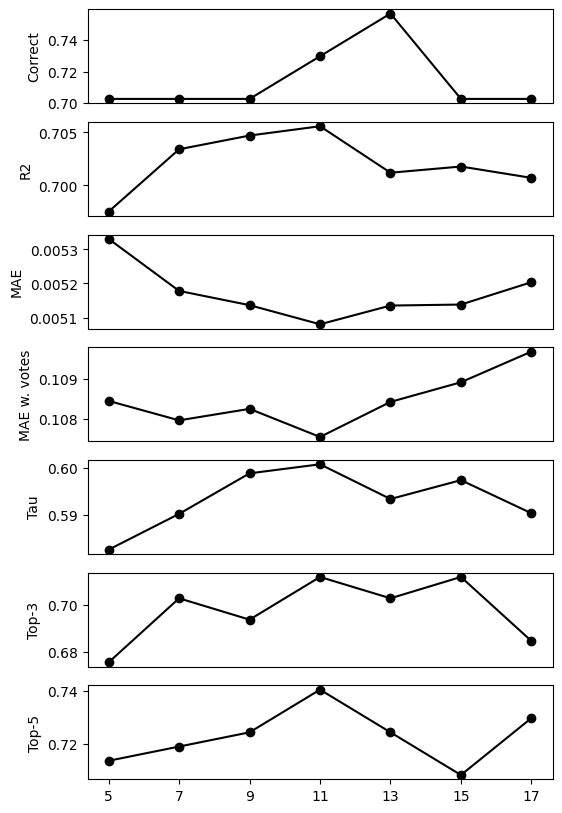

In [ ]:
_, axs = plt.subplots(7, 1, figsize = (6, 10))

for ax, metric in zip(axs, backtests.columns[-7:]) :
    metr = [bt[metric].mean() for bt in backtest_depth]
    ax.plot(max_depths, metr, 'k-o')
    ax.set_ylabel(metric)
    ax.set_xticks([])

ax.set_xticks(max_depths)

plt.show()

In [ ]:
n_estimatorss = [10, 50, 100, 250, 500]
backtest_estimators = []
for n_estimators in n_estimatorss :
    backtests = backtest(start_year, data.copy(), RandomForestRegressor(n_estimators = n_estimators), features)
    backtest_estimators.append(backtests)

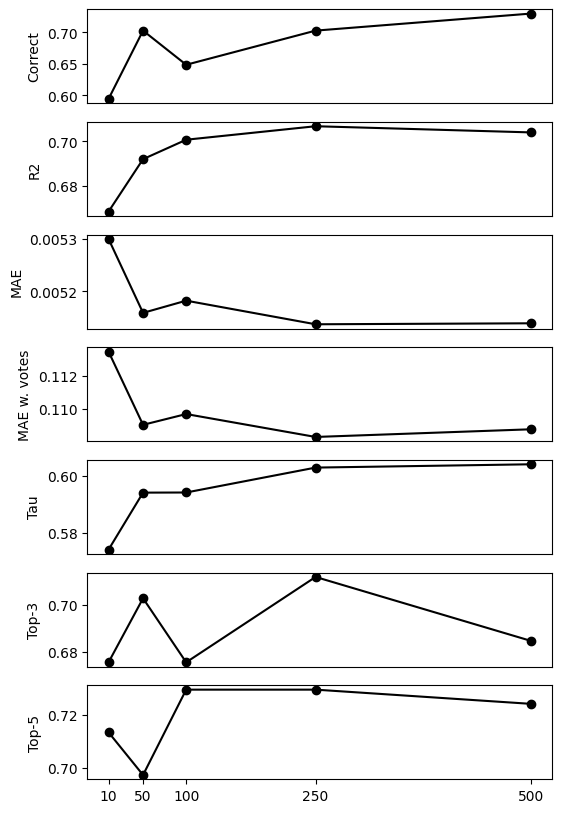

In [ ]:
_, axs = plt.subplots(7, 1, figsize = (6, 10))

for ax, metric in zip(axs, backtests.columns[-7:]) :
    metr = [bt[metric].mean() for bt in backtest_estimators]
    ax.plot(n_estimatorss, metr, 'k-o')
    ax.set_ylabel(metric)
    ax.set_xticks([])

ax.set_xticks(n_estimatorss)

plt.show()

In [ ]:
rf = RandomForestRegressor(max_depth = 12, n_estimators = 250)

backtests_rf = backtest(start_year, data.copy(), rf, features)
backtests_rf

,Winner,Pred. share,Pred. rank,Pred. winner,Share,Rank,Correct,R2,MAE,MAE w. votes,Tau,Top-3,Top-5
Year,,,,,,,,,,,,,
1988,Michael Jordan,0.573200,1,Michael Jordan,0.831,1,True,0.569961,0.008033,0.123849,0.721988,0.666667,0.8
1989,Magic Johnson,0.544912,2,Michael Jordan,0.704,2,False,0.710608,0.005781,0.078821,0.717193,0.666667,0.6
1990,Magic Johnson,0.847356,1,Magic Johnson,0.691,1,True,0.588869,0.008351,0.143888,0.700043,0.666667,0.8
1991,Michael Jordan,0.746242,1,Michael Jordan,0.928,1,True,0.811236,0.005826,0.072240,0.571437,1.000000,0.8
1992,Michael Jordan,0.908560,1,Michael Jordan,0.938,1,True,0.724248,0.005741,0.078094,0.725946,0.333333,0.8
1993,Charles Barkley,0.650897,2,Michael Jordan,0.577,3,False,0.805909,0.004851,0.103122,0.586009,1.000000,0.6
1994,Hakeem Olajuwon,0.375407,3,David Robinson,0.723,2,False,0.712979,0.005885,0.110516,0.610368,0.666667,0.8
1995,David Robinson,0.857148,1,David Robinson,0.858,1,True,0.902606,0.003228,0.059861,0.676190,1.000000,0.8
1996,Michael Jordan,0.901132,1,Michael Jordan,0.986,1,True,0.892662,0.003743,0.068830,0.617139,1.000000,0.6


## Linear Regression

In [ ]:
backtests_lr = backtest(start_year, data.copy(), LinearRegression(), features)
backtests_lr_norm = backtest(start_year, data_norm.copy(), LinearRegression(), features)

print('\nRaw data')
summarize_backtest(backtests_lr)

print('\nStandardized data')
summarize_backtest(backtests_lr_norm)

[37/37] ... 2024 ...   
Raw data
Correct 0.5135135135135135
R2 0.2776804509414299
MAE 0.02245817752495629
MAE w. votes 0.1610779438594238
Tau 0.5562948370884655
Top-3 0.7027027027027029
Top-5 0.691891891891892

Standardized data
Correct 0.5135135135135135
R2 0.285171521634096
MAE 0.023410767003965622
MAE w. votes 0.1634149538021815
Tau 0.5616372341793999
Top-3 0.7027027027027029
Top-5 0.7135135135135137


## Neural Network

In [6]:
def create_nn(hidden_layers, end_activation = 'sigmoid') :

    # Input layer
    inputs = Input(shape = (len(features),))

    x = Dense(hidden_layers[0], activation = 'relu')(inputs)
    if len(hidden_layers) > 1 :
        for hidden in hidden_layers[1:] :
            x = Dense(hidden, activation = 'relu')(x)

    # Output layer
    outputs = Dense(1, activation = end_activation)(x)

    # Construct the model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['mse', 'mae'])
    
    return model

In [7]:
nn = create_nn([64, 32, 16])

backtests_simple = backtest(2023, data.copy(), nn, features, keras = (10, 32))

[1/2] ... 2023 ...   
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.35696563668763864 1.7410220000000003
(451,) (451, 1)
[2/2] ... 2024 ...   
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
0.8107228875180597 1.684713
(452,) (452, 1)


In [ ]:
nn_simple = create_nn([16])
nn_medium = create_nn([32, 16])
nn_complex = create_nn([128, 64, 32, 16])

backtests_simple = backtest(start_year, data.copy(), nn_simple, features, keras = (10, 32))

Epoch 1/10 1988 ...   
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.7399 - mae: 0.6480 - mse: 0.5792 - val_loss: 0.4504 - val_mae: 0.1512 - val_mse: 0.0910
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2781 - mae: 0.0974 - mse: 0.0477 - val_loss: 0.2626 - val_mae: 0.0657 - val_mse: 0.0295
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1805 - mae: 0.0501 - mse: 0.0204 - val_loss: 0.1899 - val_mae: 0.0413 - val_mse: 0.0165
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 - mae: 0.0328 - mse: 0.0125 - val_loss: 0.1366 - val_mae: 0.0344 - val_mse: 0.0133
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1542 - mae: 0.0352 - mse: 0.0142 - val_loss: 0.1000 - val_mae: 0.0328 - val_mse: 0.0120
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0758 - mae: 0.0262 - mse: 0.0077 - val_loss: 0.0786 - val_mae: 0.0314 - val_mse: 0.0111
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0753 - mae: 0.0278 - mse: 0.0081 - val_

In [ ]:
backtests_complex = backtest(start_year, data.copy(), nn_complex, features, keras = (15, 32))

Epoch 1/15 1988 ...   
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1269 - mae: 0.0624 - mse: 0.0255 - val_loss: 0.0359 - val_mae: 0.0232 - val_mse: 0.0042
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0363 - mae: 0.0149 - mse: 0.0038 - val_loss: 0.0247 - val_mae: 0.0145 - val_mse: 0.0028
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - mae: 0.0077 - mse: 0.0021 - val_loss: 0.0225 - val_mae: 0.0109 - val_mse: 0.0030
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - mae: 0.0094 - mse: 0.0024 - val_loss: 0.0269 - val_mae: 0.0163 - val_mse: 0.0039
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mae: 0.0068 - mse: 0.0015 - val_loss: 0.0219 - val_mae: 0.0118 - val_mse: 0.0028
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mae: 0.0079 - mse: 0.0021 - val_loss: 0.0156 - val_mae: 0.0047 - val_mse: 0.0014
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.0068 - mse: 0.0017 - val_l

In [ ]:
summarize_backtest(backtests_simple)
print()
summarize_backtest(backtests_complex)

Correct 0.5945945945945946
R2 -695.299036106603
MAE 0.013937713910117264
MAE w. votes 0.11527366006063668
Tau 0.5726501351779603
Top-3 0.6936936936936938
Top-5 0.718918918918919

Correct 0.5945945945945946
R2 -672.4049244948862
MAE 0.013066068997930842
MAE w. votes 0.10257427585123051
Tau 0.5826251534461466
Top-3 0.7207207207207208
Top-5 0.7351351351351353


In [ ]:
nn_sigmoid = create_nn([64, 32, 16], end_activation = 'sigmoid')
nn_softmax = create_nn([64, 32, 16], end_activation = 'softmax')
nn_linear  = create_nn([64, 32, 16], end_activation = 'linear')

backtest_sigmoid = backtest(start_year, data.copy(), nn_sigmoid, features, keras = (10, 32))
backtest_softmax = backtest(start_year, data.copy(), nn_softmax, features, keras = (10, 32))
backtest_linear  = backtest(start_year, data.copy(), nn_linear, features, keras = (10, 32))

Epoch 1/10 1988 ...   
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0716 - mae: 0.0280 - mse: 0.0065 - val_loss: 0.0223 - val_mae: 0.0118 - val_mse: 0.0020
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - mae: 0.0116 - mse: 0.0024 - val_loss: 0.0185 - val_mae: 0.0093 - val_mse: 0.0010
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mae: 0.0083 - mse: 0.0024 - val_loss: 0.0179 - val_mae: 0.0085 - val_mse: 0.0013
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - mae: 0.0073 - mse: 0.0017 - val_loss: 0.0254 - val_mae: 0.0139 - val_mse: 0.0039
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253 - mae: 0.0083 - mse: 0.0025 - val_loss: 0.0183 - val_mae: 0.0064 - val_mse: 0.0025
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - mae: 0.0085 - mse: 0.0027 - val_loss: 0.0142 - val_mae: 0.0044 - val_mse: 8.4901e-04
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mae: 0.0063 - mse: 0.0012 - v

/Users/theparents/anaconda3/envs/nbaenv/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4520 - mae: 0.9914 - mse: 0.9866 - val_loss: 0.0704 - val_mae: 0.9907 - val_mse: 0.9873
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530 - mae: 0.9905 - mse: 0.9855 - val_loss: 0.0248 - val_mae: 0.9907 - val_mse: 0.9873
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mae: 0.9940 - mse: 0.9903 - val_loss: 0.0227 - val_mae: 0.9907 - val_mse: 0.9873
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - mae: 0.9927 - mse: 0.9888 - val_loss: 0.0170 - val_mae: 0.9907 - val_mse: 0.9873
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - mae: 0.9915 - mse: 0.9878 - val_loss: 0.0154 - val_mae: 0.9907 - val_mse: 0.9873
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234 - mae: 0.9921 - mse: 0.9879 - val_loss: 0.0146 - val_mae: 0.9907 - val_mse: 0.9873
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mae: 0.9912 - mse: 0.9870 - val_loss: 0.0145 - val_mae: 

/Users/theparents/anaconda3/envs/nbaenv/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/Users/theparents/anaconda3/envs/nbaenv/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mae: 0.9931 - mse: 0.9899 - val_loss: 0.0161 - val_mae: 0.9930 - val_mse: 0.9903
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.9906 - mse: 0.9861 - val_loss: 0.0151 - val_mae: 0.9930 - val_mse: 0.9903
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - mae: 0.9900 - mse: 0.9855 - val_loss: 0.0220 - val_mae: 0.9930 - val_mse: 0.9903
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mae: 0.9927 - mse: 0.9896 - val_loss: 0.0169 - val_mae: 0.9930 - val_mse: 0.9903
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mae: 0.9912 - mse: 0.9872 - val_loss: 0.0154 - val_mae: 0.9930 - val_mse: 0.9903
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - mae: 0.9919 - mse: 0.9873 - val_loss: 0.0161 - val_mae: 0.9930 - val_mse: 0.9903
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mae: 0.9888 - mse: 0.9841 - val_loss: 0.0195 - val_mae: 

In [ ]:
print('\nSigmoid')
summarize_backtest(backtest_sigmoid)

print('\nSoftmax')
summarize_backtest(backtest_softmax)

print('\nLinear')
summarize_backtest(backtest_linear)


Sigmoid
Correct 0.5945945945945946
R2 -705.0212592042164
MAE 0.013646965626228205
MAE w. votes 0.10436736526059315
Tau 0.596391410447171
Top-3 0.6936936936936938
Top-5 0.7351351351351352

Softmax
Correct 0.0
R2 -98693.44689189726
MAE 0.9932966485988909
MAE w. votes 0.8204108880466013
Tau nan
Top-3 0.009009009009009009
Top-5 0.005405405405405406

Linear
Correct 0.2972972972972973
R2 -19972716.256338593
MAE 12.899719160977185
MAE w. votes 25.265088483734033
Tau 0.4505515213413093
Top-3 0.5405405405405406
Top-5 0.6594594594594596


In [ ]:
n_epochs = [1, 5, 10, 20]
backtest_epochs = []
for epochs in n_epochs :

    nn = create_nn([64, 32, 16])
    backtests = backtest(start_year, data.copy(), nn, features, keras = (epochs, 32))
    backtest_epochs.append(backtests)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1961 - mae: 0.3396 - mse: 0.2426 - val_loss: 0.1150 - val_mae: 0.0247 - val_mse: 0.0067
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0904 - mae: 0.0217 - mse: 0.0052 - val_loss: 0.0351 - val_mae: 0.0124 - val_mse: 0.0042
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0419 - mae: 0.0175 - mse: 0.0042 - val_loss: 0.0230 - val_mae: 0.0115 - val_mse: 0.0017
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mae: 0.0091 - mse: 0.0018 - val_loss: 0.0172 - val_mae: 0.0055 - val_mse: 8.8686e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mae: 0.0081 - mse: 0.0021 - val_loss: 0.0153 - val_mae: 0.0056 - val_mse: 7.4215e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - mae: 0.0085 - mse: 0.0019 - val_loss: 0.014

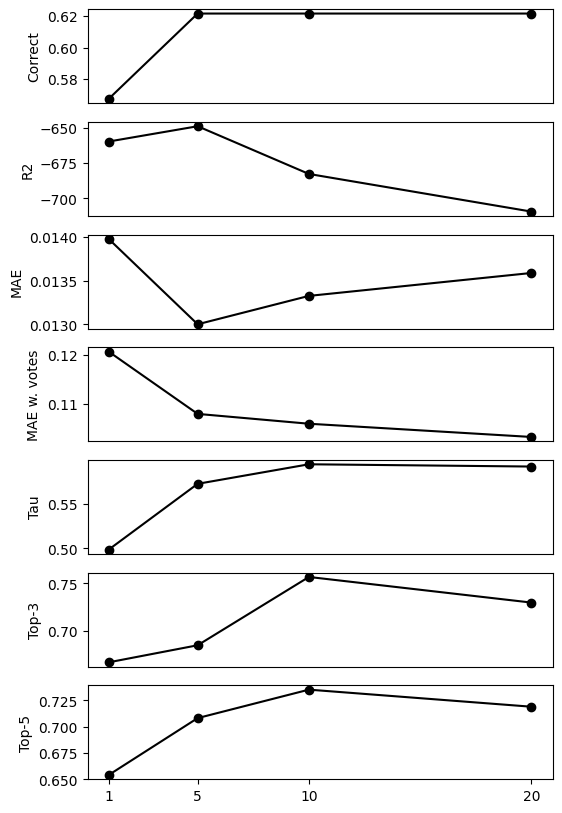

In [ ]:
_, axs = plt.subplots(7, 1, figsize = (6, 10))

for ax, metric in zip(axs, backtests.columns[-7:]) :
    metr = [bt[metric].mean() for bt in backtest_epochs]
    ax.plot(n_epochs, metr, 'k-o')
    ax.set_ylabel(metric)
    ax.set_xticks([])

ax.set_xticks(n_epochs)

plt.show()

In [ ]:
nn = create_nn([64, 32, 16])
nn_norm = create_nn([64, 32, 16])

backtest_nn = backtest(start_year, data.copy(), nn, features, keras = (10, 32))
backtest_nn_norm = backtest(start_year, data_norm.copy(), nn_norm, features, keras = (10, 32))

Epoch 1/10 1988 ...   
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6161 - mae: 0.2123 - mse: 0.1577 - val_loss: 0.1068 - val_mae: 0.0179 - val_mse: 0.0063
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0772 - mae: 0.0173 - mse: 0.0051 - val_loss: 0.0232 - val_mae: 0.0089 - val_mse: 0.0029
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0348 - mae: 0.0109 - mse: 0.0031 - val_loss: 0.0172 - val_mae: 0.0074 - val_mse: 0.0016
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - mae: 0.0088 - mse: 0.0025 - val_loss: 0.0326 - val_mae: 0.0204 - val_mse: 0.0059
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313 - mae: 0.0124 - mse: 0.0040 - val_loss: 0.0143 - val_mae: 0.0044 - val_mse: 8.0784e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mae: 0.0075 - mse: 0.0020 - val_loss: 0.0150 - val_mae: 0.0052 - val_mse: 0.0012
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - mae: 0.0094 - mse: 0.0022 - v

In [ ]:
print('\nRaw data')
summarize_backtest(backtest_nn)

print('\nStandardized data')
summarize_backtest(backtest_nn_norm)


Raw data
Correct 0.5675675675675675
R2 -670.0853580703395
MAE 0.013370489856613545
MAE w. votes 0.10639504293982119
Tau 0.5907964611535893
Top-3 0.7387387387387389
Top-5 0.7189189189189189

Standardized data
Correct 0.7027027027027027
R2 -729.024774250509
MAE 0.01357840825251132
MAE w. votes 0.09830625937197564
Tau 0.5766154382169335
Top-3 0.7117117117117118
Top-5 0.7297297297297299


In [ ]:
nn = create_nn([64, 32, 16])
backtest(2024, data_norm.copy(), nn, features, keras = (10, 32))

Epoch 1/102024 ...   
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0479 - mae: 0.0294 - mse: 0.0067 - val_loss: 0.0118 - val_mae: 0.0054 - val_mse: 0.0011
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0156 - mae: 0.0054 - mse: 0.0014 - val_loss: 0.0109 - val_mae: 0.0047 - val_mse: 8.7724e-04
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148 - mae: 0.0051 - mse: 0.0013 - val_loss: 0.0135 - val_mae: 0.0074 - val_mse: 0.0015
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130 - mae: 0.0040 - mse: 9.0331e-04 - val_loss: 0.0104 - val_mae: 0.0045 - val_mse: 7.3270e-04
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0161 - mae: 0.0053 - mse: 0.0014 - val_loss: 0.0097 - val_mae: 0.0034 - val_mse: 6.1628e-04
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0140 - mae: 0.0046 - mse: 0.0012 - val_loss: 0.0091 - val_mae: 0.0026 - val_mse: 5.0749e-04
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - 

,Winner,Pred. share,Pred. rank,Pred. winner,Share,Rank,Correct,R2,MAE,MAE w. votes,Tau,Top-3,Top-5
Year,,,,,,,,,,,,,
2024,Nikola Jokić,0.902601,1,Nikola Jokić,0.935,1,True,-844.907505,0.011339,0.083255,0.833333,0.666667,0.8


## XGBoost

In [ ]:
max_depths = [5, 7, 9, 11, 13, 15, 17]
backtest_depth = []
for max_depth in max_depths :
    backtests = backtest(start_year, data.copy(), xgb.XGBRegressor(max_depth = max_depth), features)
    backtest_depth.append(backtests)

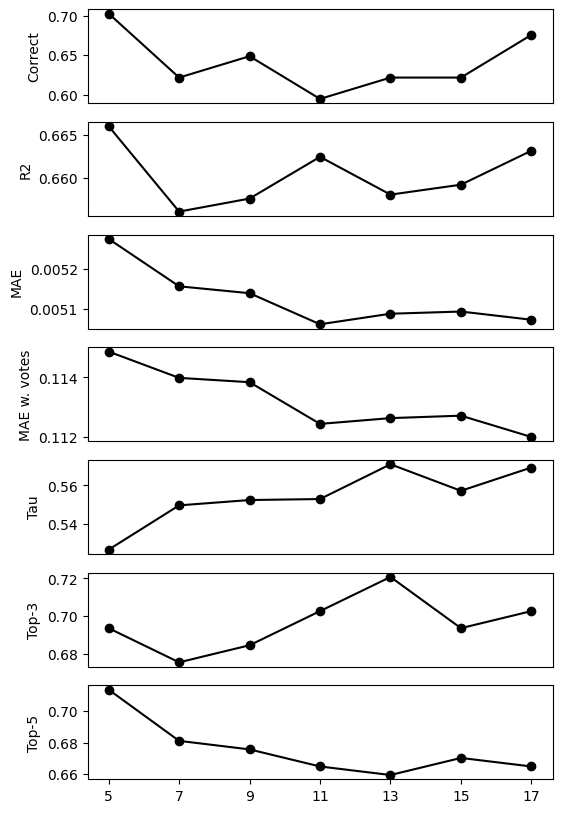

In [ ]:
_, axs = plt.subplots(7, 1, figsize = (6, 10))
for ax, metric in zip(axs, backtests.columns[-7:]) :
    metr = [bt[metric].mean() for bt in backtest_depth]
    ax.plot(max_depths, metr, 'k-o')
    ax.set_ylabel(metric)
    ax.set_xticks([])

ax.set_xticks(max_depths)

plt.show()

In [ ]:
n_estimatorss = [50, 100, 150, 200]
backtest_estimators = []
for n_estimators in n_estimatorss :
    backtests = backtest(start_year, data.copy(), xgb.XGBRegressor(n_estimators = n_estimators), features)
    backtest_estimators.append(backtests)

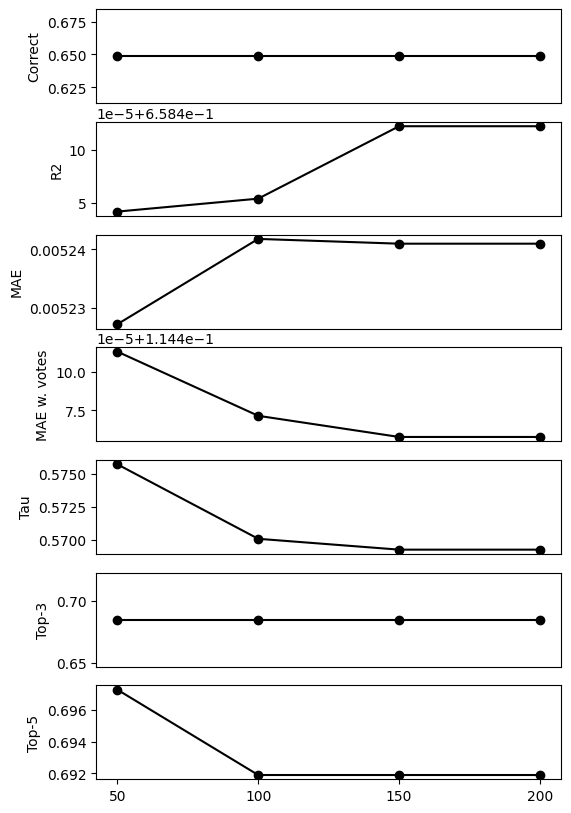

In [ ]:
_, axs = plt.subplots(7, 1, figsize = (6, 10))

for ax, metric in zip(axs, backtests.columns[-7:]) :
    metr = [bt[metric].mean() for bt in backtest_estimators]
    ax.plot(n_estimatorss, metr, 'k-o')
    ax.set_ylabel(metric)
    ax.set_xticks([])

ax.set_xticks(n_estimatorss)

plt.show()

In [ ]:
l_rates = np.linspace(0.1, 0.5, 10)
backtest_lr = []
for lr in l_rates :
    backtests = backtest(start_year, data.copy(), xgb.XGBRegressor(n_estimators = 150, learning_rate = lr), features)
    backtest_lr.append(backtests)

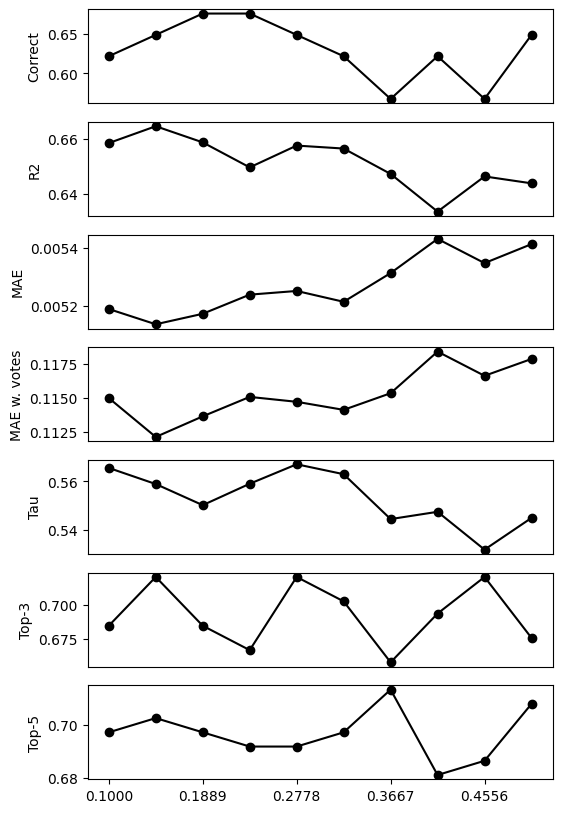

In [ ]:
_, axs = plt.subplots(7, 1, figsize = (6, 10))

for ax, metric in zip(axs, backtests.columns[-7:]) :
    metr = [bt[metric].mean() for bt in backtest_lr]
    ax.plot(l_rates, metr, 'k-o')
    ax.set_ylabel(metric)
    ax.set_xticks([])

ax.set_xticks(l_rates[::2])

plt.show()

In [ ]:
xgb.XGBRegressor(n_estimators = 150, learning_rate = lr)

Correct 0.6486486486486487
R2 0.6584541113910525
MAE 0.005241784843116022
MAE w. votes 0.11447153508814903
Tau 0.5700828036918205
Top-3 0.6846846846846848
Top-5 0.691891891891892


## Fine-tuned models

In [7]:
# 1. Linear Regression
lr = LinearRegression()

# 2. Random Forest
rf = RandomForestRegressor(n_estimators = 250, max_depth = 12)

# 3. XGBoost
xg = xgb.XGBRegressor(n_estimators = 150, learning_rate = 0.2)

# 4. Neural Network
nn = create_nn([64, 32, 16])

In [8]:
# Run backtests
backtest_lr = backtest(start_year, data.copy(), lr, features)
backtest_rf = backtest(start_year, data.copy(), rf, features)
backtest_xg = backtest(start_year, data.copy(), xg, features)
backtest_nn = backtest(start_year, data_norm.copy(), nn, features, keras = (10, 32))

[1/37] ... 1988 ...   
[2/37] ... 1989 ...   
[3/37] ... 1990 ...   
[4/37] ... 1991 ...   
[5/37] ... 1992 ...   
[6/37] ... 1993 ...   
[7/37] ... 1994 ...   
[8/37] ... 1995 ...   
[9/37] ... 1996 ...   
[10/37] ... 1997 ...   
[11/37] ... 1998 ...   
[12/37] ... 1999 ...   
[13/37] ... 2000 ...   
[14/37] ... 2001 ...   
[15/37] ... 2002 ...   
[16/37] ... 2003 ...   
[17/37] ... 2004 ...   
[18/37] ... 2005 ...   
[19/37] ... 2006 ...   
[20/37] ... 2007 ...   
[21/37] ... 2008 ...   
[22/37] ... 2009 ...   
[23/37] ... 2010 ...   
[24/37] ... 2011 ...   
[25/37] ... 2012 ...   
[26/37] ... 2013 ...   
[27/37] ... 2014 ...   
[28/37] ... 2015 ...   
[29/37] ... 2016 ...   
[30/37] ... 2017 ...   
[31/37] ... 2018 ...   
[32/37] ... 2019 ...   
[33/37] ... 2020 ...   
[34/37] ... 2021 ...   
[35/37] ... 2022 ...   
[36/37] ... 2023 ...   
[37/37] ... 2024 ...   
[1/37] ... 1988 ...   
[2/37] ... 1989 ...   
[3/37] ... 1990 ...   
[4/37] ... 1991 ...   
[5/37] ... 1992 ...   
[6/37]

Linear Reg. :  51.4%
Random Forest :  73.0%
XGBoost :  62.2%
Neural Net. :  70.3%


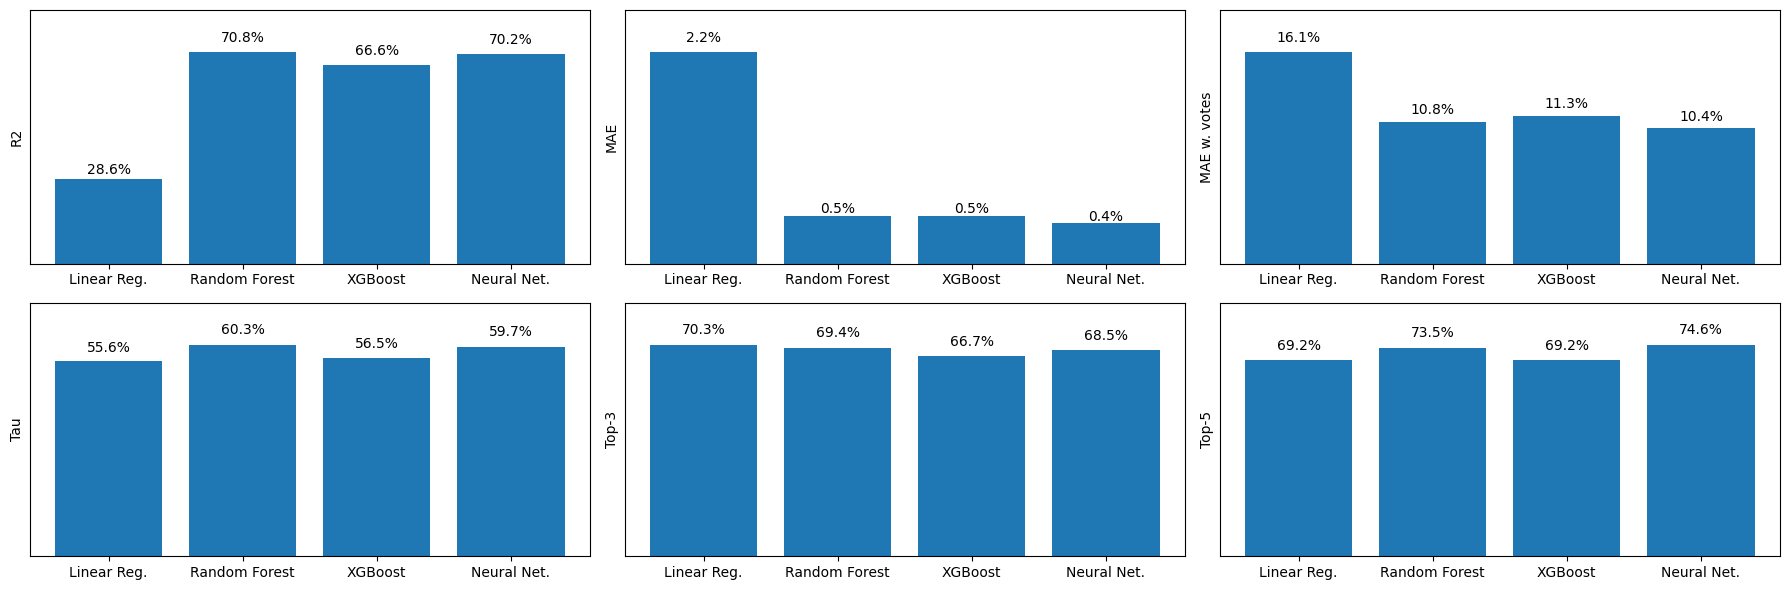

In [17]:
_, axs = plt.subplots(2, 3, figsize = (18, 6)); axs = axs.flatten()

for name, bt in zip(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'], [backtest_lr, backtest_rf, backtest_xg, backtest_nn]) :
    print(f'{name} :  {round(100*bt['Correct'].mean(), 1)}%')

for ax, metric in zip(axs, backtest_lr.columns[-6:]) :

    ax.bar(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'],
           [bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg, backtest_nn]])
    
    for i, (name, bt) in enumerate(zip(['Linear Reg.', 'Random Forest', 'XGBoost', 'Neural Net.'], [backtest_lr, backtest_rf, backtest_xg, backtest_nn])) :
        ax.text(i, 1.05 * bt[metric].mean(),  str(round(100 * bt[metric].mean(), 1)) + '%', ha = 'center')

    
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.2 * max([bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg, backtest_nn]])])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['font.family'] = 'futura'